# Data Merge Project Script

This script handles merging cleaned versions of the AirBnB Toronto and Yelp Business datasets. For details on how I created those datasets refer to this notebook: https://github.com/jkarpen/Springboard_Projects/blob/master/Capstone/Scripts/Capstone_DataWrangling_Script.ipynb 

In [1]:
#import libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
current_path = % pwd
#print(current_path)

D:\Coding Projects\Springboard\Springboard_Projects\Capstone\Scripts


In [3]:
current_path.rsplit('\\', 1)[1]

'Scripts'

In [4]:
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..
    #% pwd

D:\Coding Projects\Springboard\Springboard_Projects\Capstone


In [386]:
#Import data

#Read in AirBnB cleaned listing data for Toronto
path1='../Capstone/Data/listings_clean.csv'
abb = pd.read_csv(path1)

#Read in Yelp cleaned business data for Toronto
path2='../Capstone/Data/yelp_clean.csv'
yelp = pd.read_csv(path2)

print(abb.shape)
print(yelp.shape)

(16947, 52)
(14023, 6)


## Fix Missing Neighborhoods and Mismatches

The ultimate goal is to use the keep the AirBnB listings dataset and merge in for each listing the total number of businesses, their average star rating, and the number of reviews, for all Yelp businesses within 0.1 miles of the AirBnB listing. Without any other filtering this would involve comparing the lat/long of every single AirBnB listing (16,947) against every Yelp business (14,023). This could be very time-consuming. 

To limit the number of comparisons and make the process more manageable I plan to only compare listings in the same neighborhood, which is a variable in both datasets. There were a significant number of missing neighborhood values in each dataset, so my next step will be to use K Nearest Neighbors to predict those missing values so those records can be used. 

### Rename Mismatched Neighborhoods
First I will inspect the neighborhoods in each dataset and check how many match or do not match in each dataset. 

In [111]:
abb_hoods = pd.DataFrame(abb['neighbourhood'].value_counts().reset_index())
yelp_hoods = pd.DataFrame(yelp['neighborhood'].value_counts().reset_index())
print(abb_hoods.shape)
print(yelp_hoods.shape)
print(abb_hoods.head())
print(yelp_hoods.head())

(140, 2)
(80, 2)
                    index  neighbourhood
0        Downtown Toronto           2082
1  Entertainment District           1571
2                 Unknown            855
3                 Niagara            696
4              Willowdale            504
           index  neighborhood
0        Unknown          2842
1  Downtown Core          1317
2    Scarborough           717
3      Etobicoke           601
4      Yorkville           419


In [112]:
#Next check how many neighborhood matches there are between datasets:
match_hoods = pd.merge(abb_hoods, yelp_hoods, 
                       on=['index'], how='outer')

In [113]:
#Count records where there is no match on each side.
abb_nomatch = match_hoods.neighbourhood[match_hoods.neighborhood.isnull()]
print('There are ' + str(abb_nomatch.sum()) + ' AirBnB listings with no match in the Yelp data.')

yelp_nomatch = match_hoods.neighborhood[match_hoods.neighbourhood.isnull()]
print('There are ' + str(yelp_nomatch.sum()) + ' Yelp listings with no match in the AirBnB data.')


There are 9554.0 AirBnB listings with no match in the Yelp data.
There are 7077.0 Yelp listings with no match in the AirBnB data.


It seems there are quite a few mismatches. 9,554 out of approx. 17K records in the AirBnB dataset do not have a neighborhood match in the Yelp dataset, which is approximately 56%. On the other side 7,077 Yelp listings out of approx. 14K do not have a neighborhood match on the AirBnB side, which is around 50%. Eventually I will drop the Yelp records that don't have a match, but first I will manually inspect the names to see if there are any neighborhoods that are simply named differently in each dataset. 

In [9]:
#View matches and mismatches side by side. 
#neighbourhood column shows the count of records in the AirBnB dataset
#neighborhood (no "u") shows the count of records in the Yelp dataset. 
#NaN in neighbourhood column indicates a name that exists in Yelp but not AirBnB.
#NaN in neighborhood column indicates a name that exists in AirBnB but not Yelp. 
print(match_hoods.sort_values('index'))

                             index  neighbourhood  neighborhood
37                       Agincourt          103.0           NaN
95                       Alderwood           32.0           NaN
155                 Alexandra Park            NaN         116.0
108                       Amesbury           26.0           NaN
75                  Armour Heights           42.0           NaN
73                         Bayview           44.0           NaN
77                 Bayview Village           42.0          34.0
174           Beaconsfield Village            NaN          58.0
89                    Bedford Park           35.0           NaN
83                         Bendale           40.0           NaN
162                  Bickford Park            NaN          82.0
68                     Birch Cliff           49.0           NaN
152             Bloor-West Village            NaN         137.0
168              Bloordale Village            NaN          73.0
70                 Broadview North      

In [10]:
#Checking neighbourhood against neighbourhood_cleansed in the AirBnB dataset might also provide context
print(abb[['neighbourhood_cleansed', 'neighbourhood']].drop_duplicates().sort_values(by=['neighbourhood_cleansed', 'neighbourhood']))

                    neighbourhood_cleansed            neighbourhood
881                        Agincourt North                Agincourt
13889                      Agincourt North                  Unknown
322           Agincourt South-Malvern West                Agincourt
2170          Agincourt South-Malvern West             Malvern West
1476                             Alderwood                Alderwood
10877                            Alderwood                  Unknown
12331                                Annex                Casa Loma
1070                                 Annex         Downtown Toronto
2707                                 Annex  Palmerston/Little Italy
3488                                 Annex                 Rosedale
2                                    Annex                The Annex
463                                  Annex                  Unknown
256                                  Annex                Yorkville
308                      Banbury-Don Mills      

Inspecting the list shows a few obvious misnamings: The Beach in Yelp, The Beaches in AirBnB, for example. Where I see these I will correct the spelling in the Yelp dataset to match the AirBnB dataset. 

Others are not as obvious. The Yelp dataset has Scarborough neighborhood, while the AirBnB dataset has Scarborough City Centre, Scarborough Junction, and Scarborough Village. Consulting Wikipedia (https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto) it seems safe to group these together under Scarborough, along with other neighborhoods like Tam O'Shanter.

I will start by correcting the obvious misspellings and those that seem relevant to group.

In [387]:
#Rename Scarborough Neighborhoods as Scarborough in AirBnB
abb.neighbourhood.replace(['Agincourt', 'Scarborough Village', 'Tam O\'Shanter', 
                          'Scarborough Junction', 'Scarborough City Centre', 'Bendale', 'Birch Cliff',
                          'Clairlea', 'Cliffcrest', 'Dover Park', 'Cliffside', 'Dorset Park', 'Eglinton East',
                          'Guildwood', 'Highland Creek', 'Ionview', 'L\'Amoreaux', 'Malvern', 'Malvern West',
                          'Morningside', 'Morningside Heights', 'Oakridge', 'Port Union', 'Rouge', 'West Hill',
                          'West Rouge', 'Wexford/Maryvale', 'Woburn'],
                        'Scarborough', inplace=True)

In [388]:
#Rename Etobicoke Neighborhoods as Etobicoke in AirBnB
abb.neighbourhood.replace(['Etobicoke West Mall', 'Alderwood', 'Eringate', 'Humber Valley', 'Islington', 'Long Branch',
                          'Mimico', 'Princess', 'Richview', 'Stonegate-Queensway', 'The Elms', 'The Kingsway', 
                           'The Westway', 'Thistletown', 'West Humber', 'Westmount'],
                        'Etobicoke', inplace=True)

In [389]:
#Rename Downtown Core Neighborhoods as Downtown Core in AirBnB
abb.neighbourhood.replace(['Downtown Toronto', 'Fashion District', 'Garden District', 'Saint Andrew/Windfields',
                          'Toronto Islands'],
                        'Downtown Core', inplace=True)

In [390]:
#Rename East York neighborhoods as East York in AirBnB
abb.neighbourhood.replace(['Broadview North', 'Crescent Town', 'Old East York', 'Parkview', 'Thorncliffe Park'],
                        'East York', inplace=True)

In [391]:
#Miscellaneous AirBnB Renamings
abb.neighbourhood.replace(['Bedford Park'],
                        'Lawrence Park', inplace=True)
abb.neighbourhood.replace(['Greek Town'],
                        'Greektown', inplace=True)
abb.neighbourhood.replace(['Humberlea'],
                        'Pelmo Park', inplace=True)
abb.neighbourhood.replace(['Markland Woods'],
                        'Markland Wood', inplace=True)
abb.neighbourhood.replace(['South Hill/Rathnelly'],
                        'South Hill', inplace=True)
abb.neighbourhood.replace(['Danforth Village'],
                        'The Danforth', inplace=True)

In [392]:
#Rename Downtown Core Neighborhoods as Downtown Core in Yelp
yelp.neighborhood.replace(['Alexandra Park', 'Chinatown', 'Christie Pits', 'Church-Wellesley Village', 'City Place',
                          'Discovery District', 'Distillery District', 'Financial District', 'Queen Street West'],
                        'Downtown Core', inplace=True)

In [393]:
#Rename Scarborough Neighborhoods as Scarborough in Yelp
yelp.neighborhood.replace(['Milliken'],
                         'Scarborough', inplace=True)

In [394]:
#Rename Palmerston/Little Italy neighborhoods as Palmerston/Little Italy in Yelp
yelp.neighborhood.replace(['Palmerston', 'Little Italy'],
                        'Palmerston/Little Italy', inplace=True)

In [395]:
#Miscellaneous Yelp Renamings
yelp.neighborhood.replace(['Bickford Park'],
                        'Palmerston/Little Italy', inplace=True)
yelp.neighborhood.replace(['Dovercourt'],
                        'Dovercourt Park', inplace=True)
yelp.neighborhood.replace(['High Park'],
                        'High Park North', inplace=True)
yelp.neighborhood.replace(['Mount Pleasant and Davisville'],
                        'Davisville', inplace=True)
yelp.neighborhood.replace(['St. Lawrence'],
                        'Saint Lawrence', inplace=True)
yelp.neighborhood.replace(['The Beach'],
                        'The Beaches', inplace=True)
yelp.neighborhood.replace(['Trinity Bellwoods'],
                        'Trinity-Bellwoods', inplace=True)
yelp.neighborhood.replace(['Yonge and St. Clair'],
                        'Deer Park', inplace=True)
yelp.neighborhood.replace(['Yonge and Eglinton'],
                        'Yonge Eglinton', inplace=True)

In [161]:
#Count records where there is no match on each side.
abb_nomatch = match_hoods.neighbourhood[match_hoods.neighborhood.isnull()]
print('There are ' + str(abb_nomatch.sum()) + ' AirBnB listings with no match in the Yelp data.')

yelp_nomatch = match_hoods.neighborhood[match_hoods.neighbourhood.isnull()]
print('There are ' + str(yelp_nomatch.sum()) + ' Yelp listings with no match in the AirBnB data.')
#Check matches again
abb_hoods = pd.DataFrame(abb['neighbourhood'].value_counts().reset_index())
yelp_hoods = pd.DataFrame(yelp['neighborhood'].value_counts().reset_index())
match_hoods = pd.merge(abb_hoods, yelp_hoods, 
                       on=['index'], how='outer')
print(match_hoods.sort_values('index'))

There are 3001.0 AirBnB listings with no match in the Yelp data.
There are 1844.0 Yelp listings with no match in the AirBnB data.
                       index  neighbourhood  neighborhood
74                  Amesbury           26.0           NaN
63            Armour Heights           42.0           NaN
60                   Bayview           44.0           NaN
62           Bayview Village           42.0          34.0
102     Beaconsfield Village            NaN          58.0
89        Bloor-West Village            NaN         137.0
97         Bloordale Village            NaN          73.0
94          Brockton Village            NaN          79.0
20               Cabbagetown          217.0          76.0
75                 Casa Loma           26.0          25.0
36        Cedarvale Humewood           93.0           NaN
59              Clanton Park           49.0           NaN
69                  Corktown           34.0         228.0
103             Corso Italia            NaN          40.0


### Imputing Missing Neighborhoods with KNN
Previously in the Data Wrangling script I renamed missing Neigthborhood values with "Unknown". I now plan to predict the value for those neighborhoods by using K Nearest Neighbors. First I will create a single data frame with the Neighborhoods and Lat/Longs from both the AirBnB and Yelp datasets. Then I will split the data frame into "train" and "test" datasets. The test dataset will include all neighborhoods with the value "Unknown". Next I will run K Nearest Neighbors on the train dataset and use the resulting model to predict the values in the test dataset. 


In [297]:
#Create dfs with neighborhood, lat, long from each dataset
abb_hoods_df = abb[['id', 
                    'neighbourhood', 'latitude', 'longitude']]
abb_hoods_df = abb_hoods_df.rename(columns={'neighbourhood':'neighborhood'})
print(abb_hoods_df.head())
yelp_hoods_df = yelp[['business_id', 
                      'neighborhood', 'latitude', 'longitude']]
print(yelp_hoods_df.head())

      id       neighborhood   latitude  longitude
0   1419    Little Portugal  43.646168 -79.424510
1  10314          Riverdale  43.670186 -79.335848
2  12604          The Annex  43.667241 -79.415978
3  17936  Kensington Market  43.656400 -79.403295
4  23691           Fairbank  43.696017 -79.454683
              business_id           neighborhood   latitude  longitude
0  5J3b7j3Fzo9ISjChmoUoUA               Wychwood  43.681328 -79.427884
1  zHwXoh40k86P0aiN1aix9Q            Scarborough  43.733395 -79.224206
2  wv9KN5x8L2qzKFq_6Hzf9g     Discovery District  43.661964 -79.391259
3  RJEtBRLJmmji_QoqS6ysjg  University of Toronto  43.667749 -79.396167
4  YIez_A3WOt9J2SXN7OMa2Q                Unknown  43.745928 -79.324623


In [343]:
neighborhoods_df = pd.concat([abb_hoods_df, yelp_hoods_df], sort=True)
neighborhoods_df.shape

(30970, 5)

In [238]:
#neighborhoods_df2 = abb_hoods_df.combine_first(yelp_hoods_df)
#neighborhoods_df2.shape
#neighborhoods_df2.sort_values('neighborhood')


(16947, 5)

In [345]:
#Remove Unknown neighborhoods
#unknown_df = neighborhoods_df[neighborhoods_df['neighborhood'] == 'Unknown']
#print(unknown_df.head())
neighborhoods_df = neighborhoods_df[neighborhoods_df['neighborhood'] != 'Unknown']
print(neighborhoods_df.head())
print(neighborhoods_df.shape)

  business_id       id   latitude  longitude       neighborhood
0         NaN   1419.0  43.646168 -79.424510    Little Portugal
1         NaN  10314.0  43.670186 -79.335848          Riverdale
2         NaN  12604.0  43.667241 -79.415978          The Annex
3         NaN  17936.0  43.656400 -79.403295  Kensington Market
4         NaN  23691.0  43.696017 -79.454683           Fairbank
(27273, 5)


In [346]:
#Convert neighborhoods to numeric for prediction
le = preprocessing.LabelEncoder()
le.fit(neighborhoods_df['neighborhood'].astype(str)) #fit to list of all neighborhoods to ensure all possible values are encoded

  business_id       id   latitude  longitude       neighborhood
0         NaN   1419.0  43.646168 -79.424510    Little Portugal
1         NaN  10314.0  43.670186 -79.335848          Riverdale
2         NaN  12604.0  43.667241 -79.415978          The Annex
3         NaN  17936.0  43.656400 -79.403295  Kensington Market
4         NaN  23691.0  43.696017 -79.454683           Fairbank


In [347]:
#Create train/test split from neighborhoods_df
x = neighborhoods_df[['latitude', 'longitude']]
y = neighborhoods_df[['neighborhood', 'business_id', 'id']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [350]:
y_train['neighborhood'] = le.transform(y_train['neighborhood'].astype(str))
y_test['neighborhood'] = le.transform(y_test['neighborhood'].astype(str))
#print(y_train)
#Code below converts back to original values
#print("")
#y_train['neighborhood'] = le.inverse_transform(y_train['neighborhood'])
#print(y_train)

ValueError: y contains new labels: ['0' '1' '10' '100' '101' '102' '103' '104' '105' '106' '107' '108' '109'
 '11' '110' '111' '112' '113' '114' '115' '116' '117' '118' '119' '12'
 '120' '121' '122' '123' '124' '125' '126' '127' '128' '129' '13' '130'
 '131' '132' '133' '134' '135' '136' '137' '138' '139' '14' '140' '141'
 '142' '143' '144' '145' '146' '147' '148' '149' '15' '150' '151' '152'
 '153' '154' '155' '156' '157' '158' '159' '16' '160' '161' '162' '163'
 '164' '165' '166' '167' '168' '169' '17' '170' '171' '172' '173' '174'
 '175' '176' '177' '178' '179' '18' '180' '181' '182' '183' '184' '185'
 '186' '187' '188' '189' '19' '2' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '3' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '4' '40'
 '41' '42' '43' '44' '45' '46' '47' '48' '49' '5' '50' '51' '52' '53' '54'
 '55' '56' '57' '58' '59' '6' '60' '61' '62' '63' '64' '65' '66' '67' '68'
 '69' '7' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '8' '80' '81'
 '82' '83' '84' '85' '86' '87' '88' '89' '9' '90' '91' '92' '93' '94' '95'
 '96' '97' '98' '99']

In [353]:
# Scale lat/long before modeling
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [354]:
# Run K Means on training set
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [355]:
#Make predictions
y_pred = classifier.predict(x_test)

In [356]:
# Evaluate model
print(confusion_matrix(y_test.loc[:, 'neighborhood'], y_pred))
print(classification_report(y_test.loc[:, 'neighborhood'], y_pred))

[[ 16   0   0 ...   0   0   0]
 [  0   4   0 ...   0   0   0]
 [  0   0  22 ...   0   0   0]
 ...
 [  0   0   0 ...  13   0   0]
 [  0   0   0 ...   0  30   0]
 [  0   0   0 ...   0   0 113]]
             precision    recall  f1-score   support

          0       0.80      0.80      0.80        20
          1       1.00      0.50      0.67         8
          2       0.85      0.88      0.86        25
          3       0.75      0.75      0.75         4
          4       0.78      0.78      0.78         9
          5       0.83      1.00      0.91        10
          6       0.88      0.78      0.82        18
          7       0.64      0.60      0.62        15
          8       0.75      0.86      0.80         7
          9       0.89      1.00      0.94         8
         10       0.70      1.00      0.82        14
         11       0.43      0.60      0.50         5
         12       0.72      0.88      0.79        26
         13       0.77      0.77      0.77        13
         14 

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The above predictions were good for most of the data, but I want to confirm I used the best value for K. Possibly setting 5 as the n_neighbors parameter was not the best value, so I will try  the below loop to test multiple values and use a plot to determine the best outcome. 

In [358]:
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test.loc[:, 'neighborhood']))

Text(0,0.5,'Mean Error')

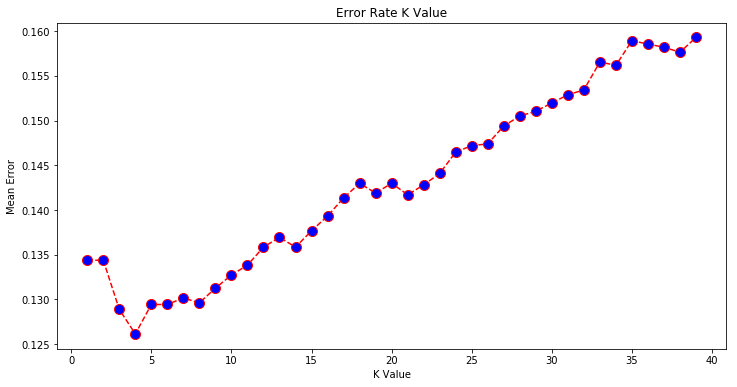

In [359]:
#Plot the errors against the various k values
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
        markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

None of the models does worse than 16% error (84% accuracy), but k=4 seems to do the best at just over 12.5% mean error. I will change the parameter and run it one more time, then use the model to predict the "Unknown" values. 

In [361]:
# Run K Means on training set, this time setting n_neighbors=4
classifier = KNeighborsClassifier(n_neighbors=4, weights='distance')
classifier.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())

#Make predictions
y_pred = classifier.predict(x_test)

### Predict neighborhood in AirBnB dataset

In [362]:
#Use the model to predict the Unknown neighborhoods in AirBnB data.
abb_copy = abb.loc[abb['neighbourhood']=='Unknown', ['id', 'latitude', 'longitude', 'neighbourhood']]

#Transform
abb_copy[['latitude', 'longitude']] = scaler.transform(abb_copy[['latitude', 'longitude']])

#Create a new column containing transformed values of neighbourhood
abb_copy['neighborhood'] = None

abb_copy.head()

,id,latitude,longitude,neighbourhood,neighborhood
19,64645,-0.686102,-0.220598,Unknown,None
24,77021,-0.444398,-0.136025,Unknown,None
25,84076,-0.714928,-0.155183,Unknown,None
52,188083,0.611141,2.382475,Unknown,None
70,248941,0.129701,-1.056887,Unknown,None


In [363]:
#Predict values of neighborhood
abb_copy['neighborhood'] = classifier.predict(abb_copy[['latitude', 'longitude']])

#Convert neighborhood back to original text values (instead of numeric)
abb_copy['neighborhood'] = le.inverse_transform(abb_copy['neighborhood'])
abb_copy.head()

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,id,latitude,longitude,neighbourhood,neighborhood
19,64645,-0.686102,-0.220598,Unknown,Niagara
24,77021,-0.444398,-0.136025,Unknown,Kensington Market
25,84076,-0.714928,-0.155183,Unknown,Niagara
52,188083,0.611141,2.382475,Unknown,Scarborough
70,248941,0.129701,-1.056887,Unknown,Fairbank


In [396]:
#Merge predicted neighborhood back into abb
abb = pd.merge(abb, abb_copy, how='outer', on='id')

In [411]:
#abb.head()
abb[abb['neighbourhood_x'] == 'Unknown'].head()
#abb.loc[abb['neighbourhood_x']=='Unknown', 'neighbourhood_x']

,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_verifications,neighbourhood_x,neighbourhood_cleansed,latitude_x,longitude_x,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,host_neighbourhood_notNA,host_response_time_notNA,host_is_superhost_notNA,neighbourhood_notNA,neighbourhood_cleansed_notNA,latitude_y,longitude_y,neighbourhood_y,neighborhood


In [412]:
#Replace unknown values
#abb['neighbourhood_x'] = np.where(abb['neighbourhood_x'] == 'Unknown', 'neighbourhood_y')
abb.loc[abb['neighbourhood_x']=='Unknown', 'neighbourhood_x'] = abb.loc[abb['neighbourhood_x']=='Unknown', 'neighborhood']

In [414]:
#Drop unecessary columns
abb.drop(columns=['latitude_y', 'longitude_y', 'neighbourhood_y', 'neighborhood'], inplace=True)
abb.head()

,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_verifications,neighbourhood_x,neighbourhood_cleansed,latitude_x,longitude_x,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,host_neighbourhood_notNA,host_response_time_notNA,host_is_superhost_notNA,neighbourhood_notNA,neighbourhood_cleansed_notNA
0,1419,https://www.airbnb.com/rooms/1419,within an hour,0.0,f,Commercial Drive,"['email', 'phone', 'reviews', 'jumio', 'govern...",Little Portugal,Little Portugal,43.646168,-79.424510,f,House,Entire home/apt,6.0,2.0,3.0,4.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",470.0,1000.0,150.0,1.0,0.0,4.0,6 months ago,t,0,0,0,0,f,strict_14_with_grace_period,f,f,0.19,True,False,True,True,True,True,True,True,False,True,True,False,True,True,True
1,10314,https://www.airbnb.com/rooms/10314,within an hour,0.0,f,Riverdale,"['email', 'phone', 'reviews', 'jumio', 'govern...",Riverdale,South Riverdale,43.670186,-79.335848,t,House,Private room,2.0,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",69.0,0.0,0.0,2.0,20.0,1.0,11 months ago,t,0,0,21,296,f,moderate,f,f,0.71,False,True,True,True,True,True,False,False,False,True,True,False,True,True,True
2,12604,https://www.airbnb.com/rooms/12604,within an hour,0.0,f,The Annex,"['email', 'phone', 'reviews', 'jumio', 'govern...",The Annex,Annex,43.667241,-79.415978,t,House,Private room,1.0,1.5,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets live on this property"",Ca...",65.0,130.0,26.0,1.0,20.0,1.0,yesterday,t,0,0,0,0,f,moderate,f,f,0.00,True,True,True,True,True,True,True,True,False,False,True,False,True,True,True
3,17936,https://www.airbnb.com/rooms/17936,within an hour,100.0,t,Kensington Market,"['email', 'phone', 'facebook', 'reviews', 'jum...",Kensington Market,Kensington-Chinatown,43.656400,-79.403295,t,Apartment,Private room,4.0,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",99.0,300.0,80.0,1.0,20.0,2.0,4 days ago,t,5,5,23,23,f,strict_14_with_grace_period,f,f,1.18,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,23691,https://www.airbnb.com/rooms/23691,within an hour,100.0,t,Fairbank,"['email', 'phone', 'facebook', 'reviews', 'jum...",Fairbank,Briar Hill-Belgravia,43.696017,-79.454683,t,House,Private room,2.0,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",70.0,0.0,0.0,2.0,25.0,1.0,today,t,0,10,40,315,t,strict_14_with_grace_period,f,f,2.02,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### Predict neighborhood in Yelp dataset

In [365]:
#Use the model to predict the Unknown neighborhoods in Yelp data.
yelp_copy = yelp.loc[yelp['neighborhood']=='Unknown', ['business_id', 'latitude', 'longitude', 'neighborhood']]

#Transform
yelp_copy[['latitude', 'longitude']] = scaler.transform(yelp_copy[['latitude', 'longitude']])

#Create a new column containing transformed values of neighbourhood
yelp_copy['neighborhood'] = None

yelp_copy.head()

,business_id,latitude,longitude,neighborhood
4,YIez_A3WOt9J2SXN7OMa2Q,1.560735,1.144327,None
6,Ea5a2Ov4s_D3Vx4j7jkEEg,0.604665,-0.332874,None
15,2tg7rpwAbrex81bMKOnOtQ,0.509307,0.573375,None
22,G4TJIm3bho3Hb3K2usIo4Q,1.354074,-0.637524,None
29,mHdichTxwzXI7n7lWNCj0Q,1.325471,-0.404878,None


In [366]:
#Predict values of neighborhood
yelp_copy['neighborhood'] = classifier.predict(yelp_copy[['latitude', 'longitude']])

#Convert neighborhood back to original text values (instead of numeric)
yelp_copy['neighborhood'] = le.inverse_transform(yelp_copy['neighborhood'])
yelp_copy.head()

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,business_id,latitude,longitude,neighborhood
4,YIez_A3WOt9J2SXN7OMa2Q,1.560735,1.144327,Parkwoods
6,Ea5a2Ov4s_D3Vx4j7jkEEg,0.604665,-0.332874,Forest Hill
15,2tg7rpwAbrex81bMKOnOtQ,0.509307,0.573375,Leaside
22,G4TJIm3bho3Hb3K2usIo4Q,1.354074,-0.637524,Clanton Park
29,mHdichTxwzXI7n7lWNCj0Q,1.325471,-0.404878,Nortown


In [ ]:
#Merge predictions back into Yelp dataset

## Merge abb and yelp datasets by computing distance

In [ ]:
#Function to compute distance between two lat/longs
#Taken from: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians

def compute_distance():
    '''
    
    '''

# approximate radius of earth in km
R = 6373.0

lat1 = radians(52.2296756)
lon1 = radians(21.0122287)
lat2 = radians(52.406374)
lon2 = radians(16.9251681)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

In [ ]:
#Make df that’s columns airbnb_id, neighborhood, lat, long, and second business_id, neighborhood, lat, long 

In [ ]:
#merge on neighborhood (the two dfs created above)

In [ ]:
#apply function to generate distance: 
#https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe 
#filter for distance < .1 mile (or whatever distances you want to try - maybe .01 too) 

In [ ]:
#Group by airbnb_id with count to get number of business in that distance 
#Also avg. star rating and number of reviews